<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/2-2-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 이미지 분할

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org에서 보기</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 튜토리얼은 수정된 <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>을 사용하여 이미지 분할 작업에 중점을 둡니다.

## 이미지 분할이란?

이미지 분류 작업에서 네트워크는 각 입력 이미지에 레이블(또는 클래스)을 할당합니다. 그러나 해당 객체의 모양, 어떤 픽셀이 어떤 객체에 속하는지 등을 알고 싶다고 가정해 보겠습니다. 이 경우 이미지의 각 픽셀에 클래스를 할당해야 할 것입니다. 이 작업을 세분화라고 합니다. 세분화 모델은 이미지에 대한 훨씬 더 자세한 정보를 반환합니다. 이미지 분할은 의료 영상, 자율 주행 자동차, 위성 영상 등 여러 분야에 응용됩니다.

이 튜토리얼은 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)([Parkhi 등, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf))을 사용합니다. 이 데이터세트는 37개의 애완동물 품종의 이미지로 구성되어 있으며 품종당 200개의 이미지가 있습니다(훈련 및 테스트 분할에 각각 ~100개). 각 이미지에는 해당 레이블과 픽셀 단위 마스크가 포함됩니다. 마스크는 각 픽셀에 대한 클래스 레이블입니다. 각 픽셀에는 세 가지 범주 중 하나가 지정됩니다.

- 클래스 1: 애완 동물에 속하는 픽셀
- 클래스 2: 애완동물과 접하는 픽셀
- 클래스 3: 위에 속하지 않음/주변 픽셀

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0glm7aio
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-0glm7aio
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=f44cb2b085bb484ed97b2f147a66c4499f50a71e54bd60545e65434f9ed0a9d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-35u59giv/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Pets 데이터 세트를 다운로드 하기

데이터세트는 [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)에서 사용할 수 있습니다. 세분화 마스크는 버전 3+에 포함되어 있습니다.

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.E40PDE_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.E40PDE_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


또한 이미지 색상 값은 `[0,1]` 범위로 정규화됩니다. 마지막으로 위에서 언급한 것처럼 분할 마스크의 픽셀에는 {1, 2, 3}이라는 레이블이 지정됩니다. 편의를 위해 세분화 마스크에서 1을 빼면 {0, 1, 2}와 같은 레이블이 생성됩니다.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

데이터세트에는 이미 필요한 훈련 및 테스트 분할이 포함되어 있으므로 동일한 분할을 계속 사용하세요.

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

다음 클래스는 이미지를 무작위로 뒤집어 간단한 증강을 수행합니다. 자세히 알아보려면 [이미지 증강](data_augmentation.ipynb) 튜토리얼로 이동하세요.


In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

입력을 일괄 처리한 후 증강을 적용하여 입력 파이프라인을 빌드합니다.

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

데이터세트에서 이미지 예제와 해당 마스크를 시각화합니다.

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

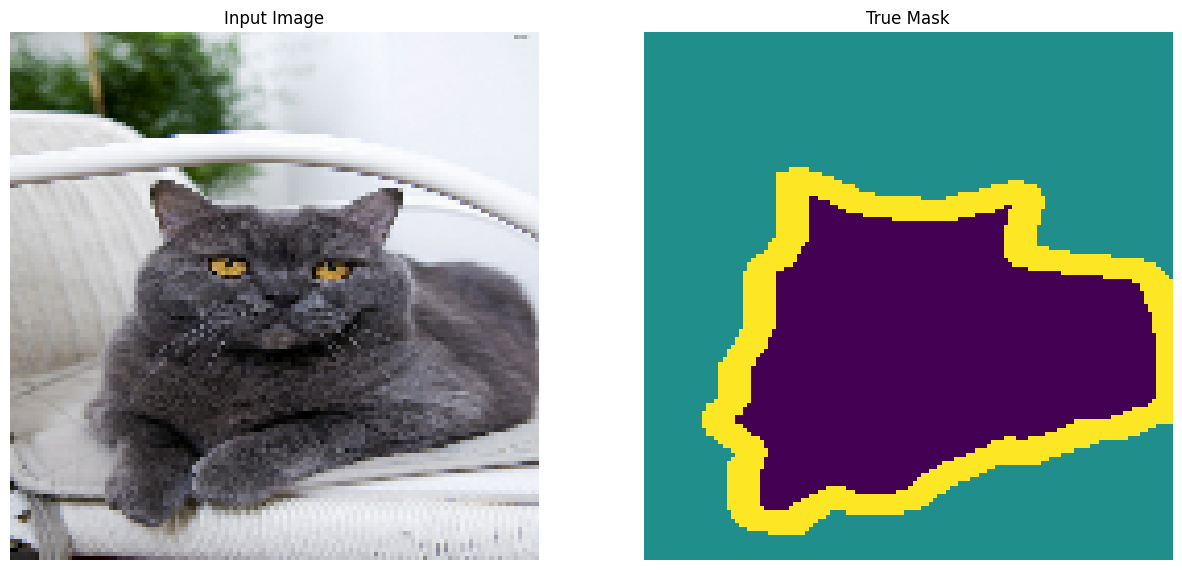

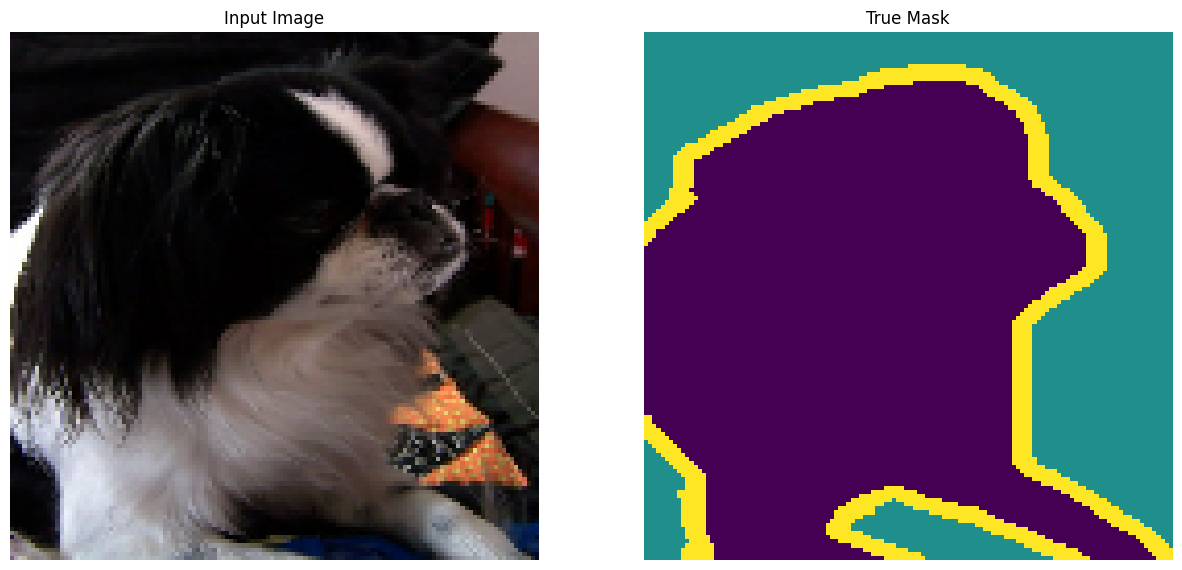

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## 모델 정의하기

여기에 사용된 모델은 수정된 [U-Net](https://arxiv.org/abs/1505.04597)입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)로 구성됩니다. 강력한 기능을 학습하고 학습 가능한 매개변수의 수를 줄이기 위해 사전 학습된 모델인 [MobileNetV2](https://arxiv.org/abs/1801.04381)를 인코더로 사용합니다. 디코더의 경우 TensorFlow 예제 리포지토리의 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 예제에서 이미 구현된 업샘플 블록을 사용합니다. 노트북에서 [pix2pix: 조건부 GAN을 사용한 이미지 대 이미지 변환](../generative/pix2pix.ipynb) 튜토리얼을 확인하세요.


언급했듯이 인코더는 사전 학습된 MobileNetV2 모델입니다. `tf.keras.applications`의 모델을 사용합니다. 인코더는 모델의 중간 레이어에서 얻어지는 특정 출력으로 구성됩니다. 인코더는 학습 과정에서 훈련되지 않습니다.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


디코더/업샘플러는 TensorFlow 예제에서 구현된 일련의 업샘플 블록입니다.

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

마지막 레이어의 필터 수는 `output_channels`의 수로 설정됩니다. 이것은 클래스당 하나의 출력 채널이 됩니다.

## 모델 훈련하기

이제 모델을 컴파일하고 훈련하는 일만 남았습니다.

이것은 다중 클래스 분류 문제이므로 `from_logits` 인수가 `True`로 설정된 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 사용하세요. 레이블은 모든 클래스의 각 픽셀에 대한 스코어 벡터가 아니라 스칼라 정수이기 때문입니다.

추론을 실행할 때 픽셀에 할당된 레이블은 값이 가장 높은 채널입니다. 이것이 `create_mask` 함수가 하는 일입니다.

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

결과적인 모델 아키텍처를 플로팅합니다.

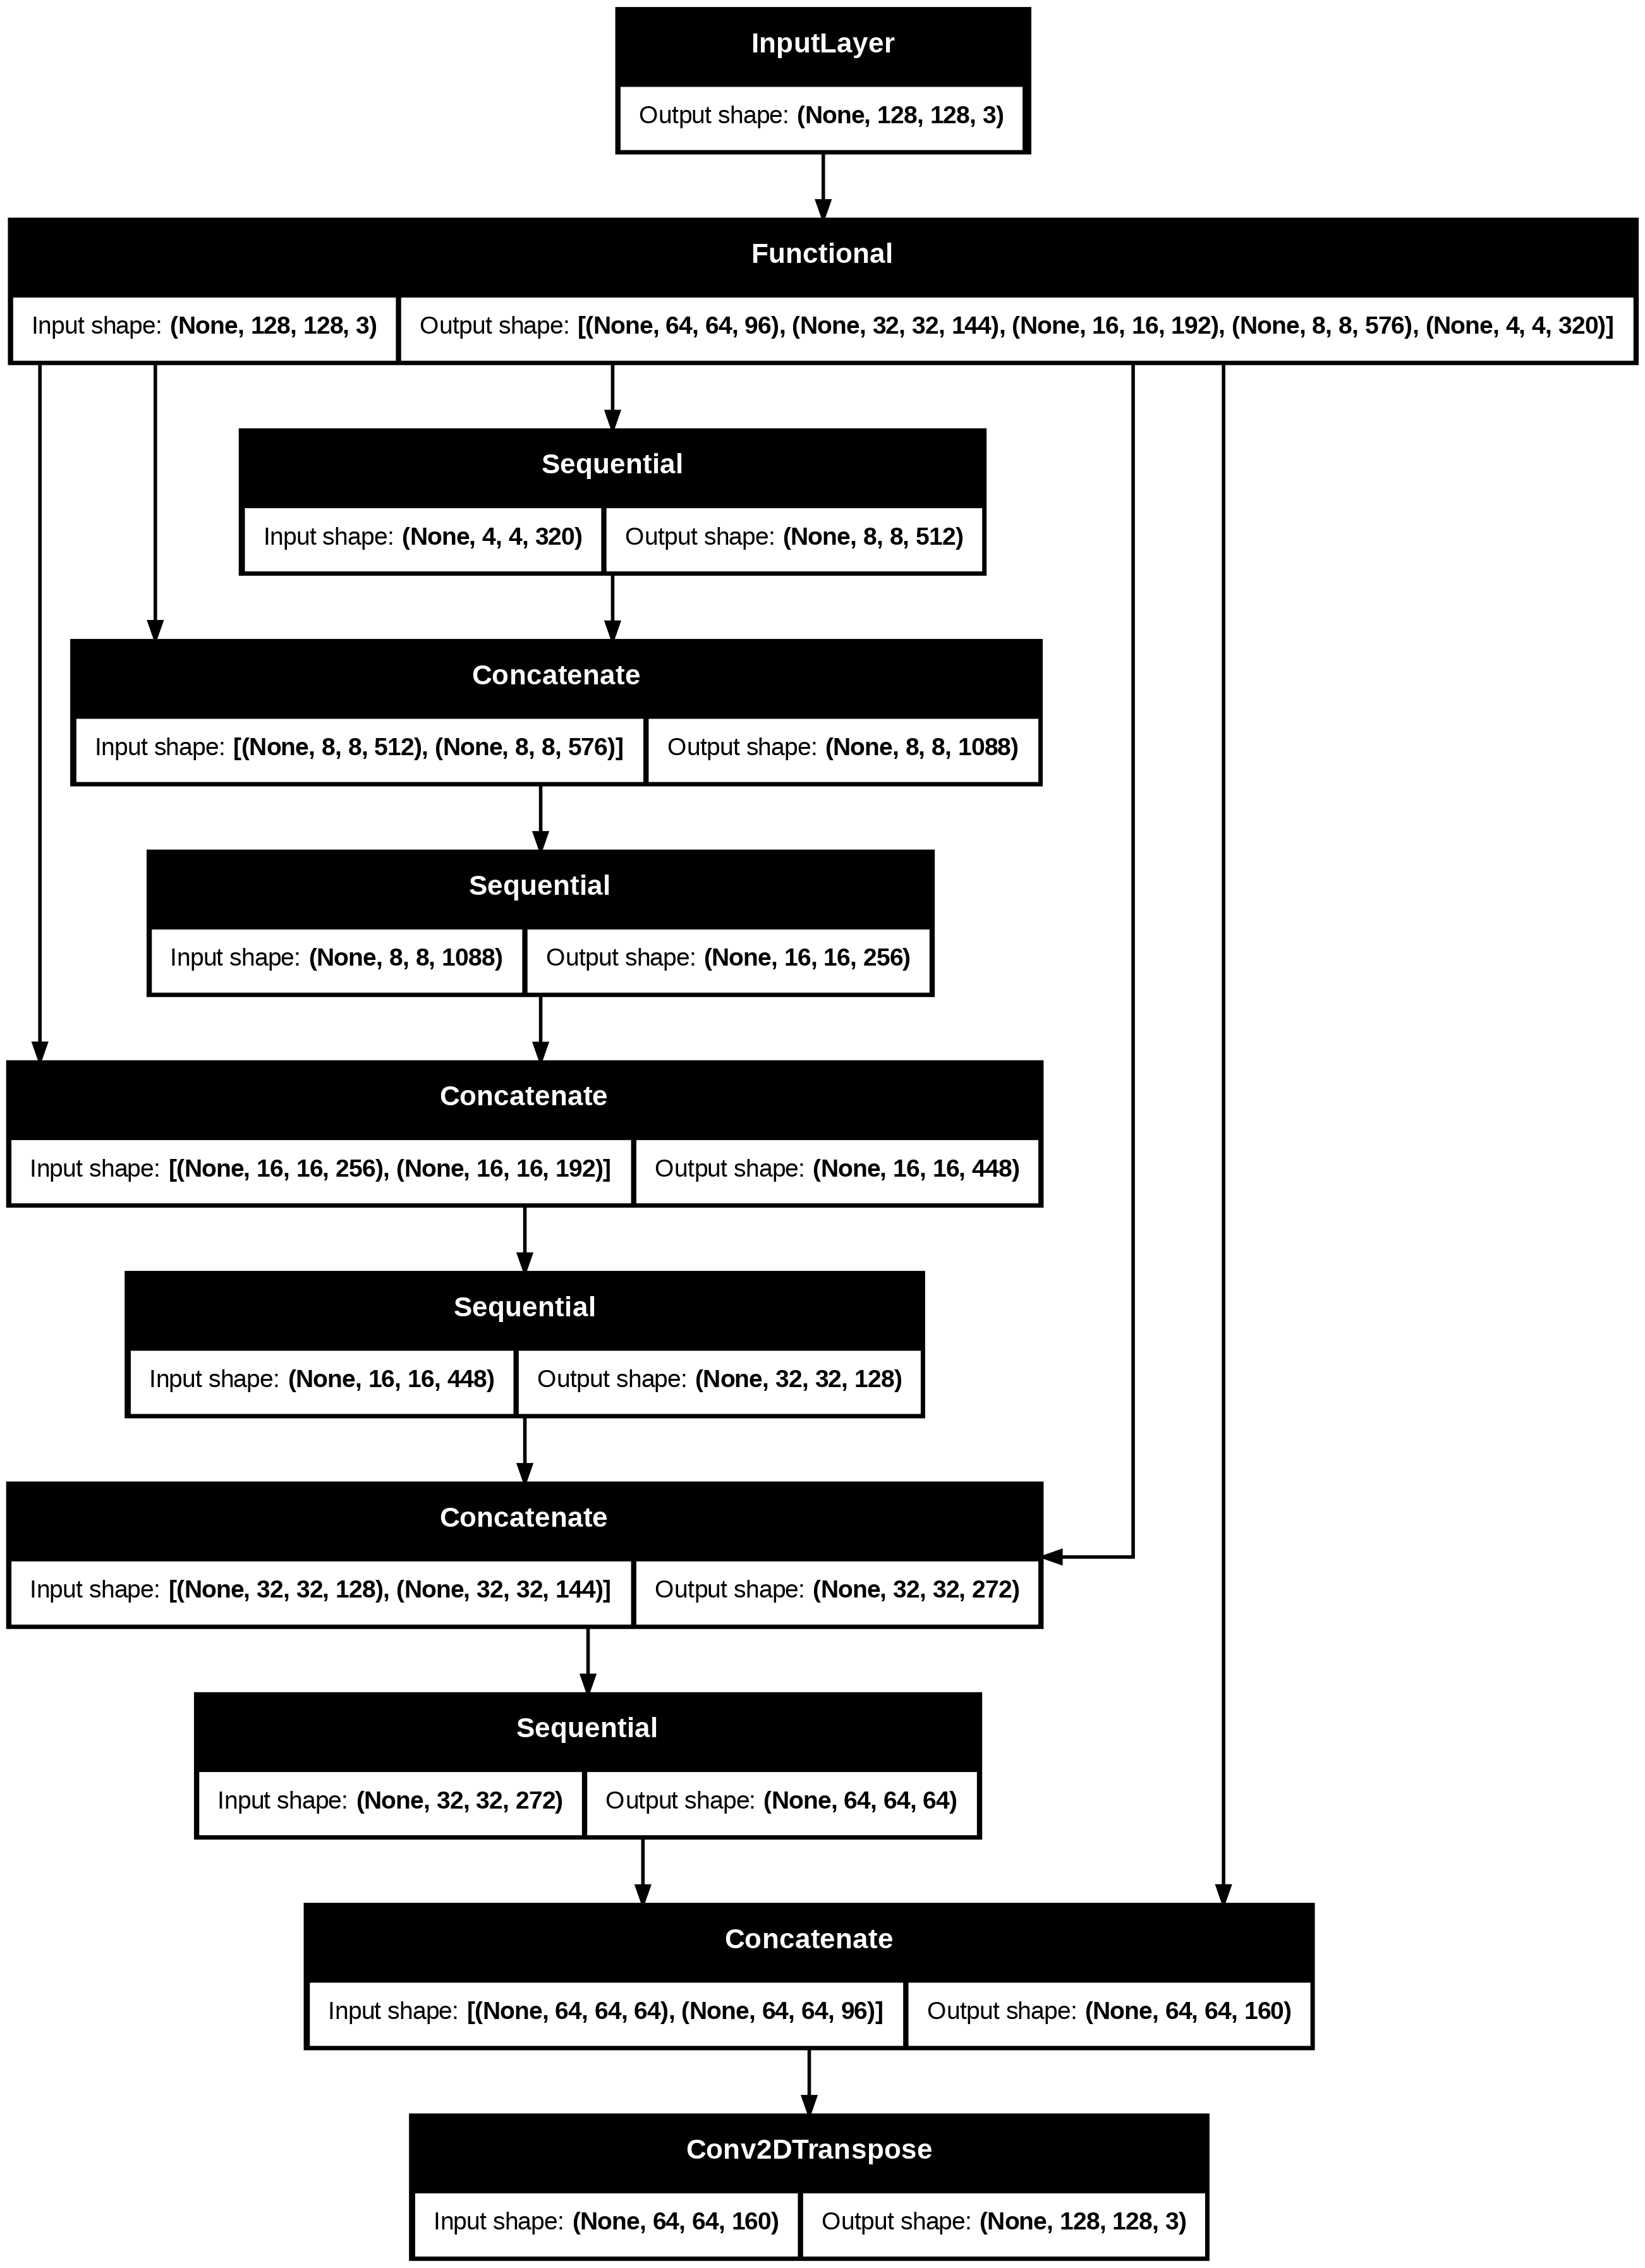

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

훈련 전에 모델이 예측하는 것을 확인하기 위해 모델을 시험해 보세요.

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


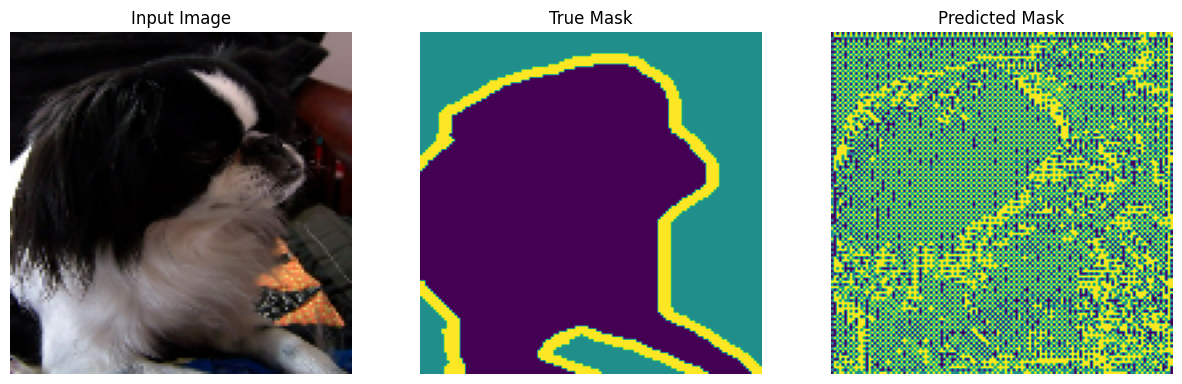

In [21]:
show_predictions()

아래에 정의된 콜백은 모델이 훈련되는 동안 어떻게 개선되는지 관찰하는 데 사용됩니다.

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


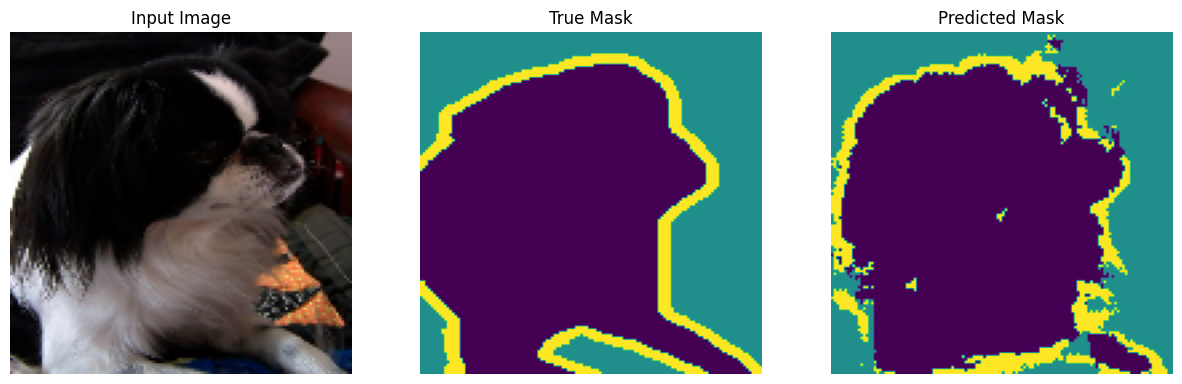


Sample Prediction after epoch 4

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8962 - loss: 0.2676 - val_accuracy: 0.8936 - val_loss: 0.2842
Epoch 5/20
25/57 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9002 - loss: 0.2570

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 예측하기

이제 몇 가지 예측을 하겠습니다. 시간을 절약하기 위해 epoch 수를 작게 유지했지만 더 정확한 결과를 얻으려면 이 값을 더 높게 설정할 수 있습니다.

In [ ]:
show_predictions(test_batches, 3)

## 옵션: 불균형 클래스 및 클래스 가중치

시맨틱 분할 데이터세트는 불균형이 심할 수 있습니다. 즉, 특정 클래스 픽셀이 다른 클래스의 픽셀보다 이미지 내부에 더 많이 존재할 수 있습니다. 분할 문제는 픽셀별 분류 문제로 취급될 수 있으므로, 이를 설명하기 위해 손실 함수에 가중치를 주어 불균형 문제를 처리할 수 있습니다. 이것이 이 문제를 처리하는 간단하고 무리 없는 방법입니다. 자세한 내용은 [불균형 데이터에 대한 분류](../structured_data/imbalanced_data.ipynb) 튜토리얼을 참조하세요.

[모호성을 피하기 위해](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748) `Model.fit`은 3차원 이상의 대상에 대해 `class_weight` 인수를 지원하지 않습니다.

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

따라서 이 경우 가중치를 직접 구현해야 합니다. 샘플 가중치를 사용하여 이 작업을 수행합니다. `(data, label)` 쌍 외에 `Model.fit`는 `(data, label, sample_weight)` 트리플도 허용합니다.

Keras `Model.fit`은 `sample_weight`를 손실 및 메트릭으로 전파하며 `sample_weight` 인수도 허용합니다. 샘플 가중치는 감소 단계 이전의 샘플 값으로 곱해집니다. 예를 들면 다음과 같습니다.

In [ ]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

따라서 이 튜토리얼을 위한 샘플 가중치를 만들려면 `(data, label)` 쌍을 받아서 `(data, label, sample_weight)` 트리플을 반환하는 함수가 필요합니다. 여기서 `sample_weight`는 각 픽셀에 대한 클래스 가중치를 포함하는 1채널 이미지입니다.

가장 간단한 구현은 레이블을 `class_weight` 목록에 대한 인덱스로 사용하는 것입니다.

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

결과 데이터세트 요소에는 각각 3개의 이미지가 포함됩니다.

In [ ]:
train_batches.map(add_sample_weights).element_spec

이제 가중치 적용된 이 데이터세트에서 모델을 훈련할 수 있습니다.

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

## 다음 단계

이제 이미지 분할이 무엇이며 어떻게 작동하는지 이해했으므로 다른 중간 레이어 출력 또는 다른 사전 훈련된 모델을 사용하여 이 튜토리얼을 시험해 볼 수 있습니다. Kaggle에서 호스팅되는 [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 이미지 마스킹 챌린지를 통해 자신을 테스트해볼 수도 있습니다.

자체 데이터에 대해 재학습할 수 있는 다른 모델에 대한 [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md)를 보고 싶을 수도 있을 것입니다. [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional)에서 사전 훈련된 모델을 사용할 수 있습니다.